# Interpreting Deep Learning with RUNE
In this notebook, we will explore how to use the `rune` library to build and, more importantly, interpret a deep learning model on a real-world dataset.

**RUNE (Rule-based Neural-network)** is an architecture that combines the expressive power of deep networks with the interpretability of rule-based models. It leverages operations from tropical algebra (max-plus) to create decision-making paths that can be traced and analyzed.

We will perform the following steps:
1.  **Setup**: Install `torch`, `rune`, and other necessary packages.
2.  **Data Preparation**: Load and preprocess the California Housing dataset.
3.  **Model Definition**: Define a fully interpretable `InterpretableRuneNet` model.
4.  **Training**: Train the model on the regression task of predicting housing prices.
5.  **Interpretation**: Use `rune`'s built-in tools to "look inside" the model and understand how it makes decisions.

Let's get started!

In [1]:
# Install libraries quietly (-q)
!pip install -q torch matplotlib networkx
!pip install -q git+https://github.com/EmotionEngineer/rune.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 1. Import Libraries
Now, let's import all the necessary components. We'll add a check to ensure `rune` was successfully installed and imported.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
import pprint

# Check if RUNE was installed and is accessible
try:
    from rune import models, interpret
    print("RUNE package imported successfully!")
except ImportError as e:
    print(f"Error importing RUNE: {e}")
    print("Please ensure the RUNE package is installed in your current environment.")
    raise

RUNE package imported successfully!


## 2. Load and Preprocess Data
We will use the classic **California Housing** dataset from `scikit-learn`. Our task is to predict the median house value in a block based on 8 features (median income, house age, etc.).

In [3]:
print("Loading California Housing dataset...")
housing = fetch_california_housing()
X_data, y_data = housing.data, housing.target

feature_names_real = housing.feature_names
print(f"Original shapes: X: {X_data.shape}, y: {y_data.shape}")
print(f"Feature names: {feature_names_real}")

# Reshape y and cast types
y_data = y_data.reshape(-1, 1).astype(np.float32)
X_data = X_data.astype(np.float32)

Loading California Housing dataset...
Original shapes: X: (20640, 8), y: (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Deep learning models generally perform better with normalized data. We'll use `StandardScaler` to scale both the features (X) and the target variable (y).

In [4]:
# Scale the data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

print(f"\nTraining tensor shapes: X: {X_train_tensor.shape}, y: {y_train_tensor.shape}")
print(f"Test tensor shapes: X: {X_test_tensor.shape}, y: {y_test_tensor.shape}")


Training tensor shapes: X: torch.Size([16512, 8]), y: torch.Size([16512, 1])
Test tensor shapes: X: torch.Size([4128, 8]), y: torch.Size([4128, 1])


## 3. Define the RUNE Model
Now we'll create our model. We will use `InterpretableRuneNet`, a special version of RUNE that avoids a "black box" final MLP layer. Instead, its output is a direct linear combination of the features generated by the last RUNE block, making the entire architecture fully transparent.

In [5]:
INPUT_DIM = X_data.shape[1]      # 8 features
OUTPUT_DIM = 1                   # 1 output (regression)
BLOCK_DIM = 32                   # Internal dimension for RUNE blocks
NUM_BLOCKS = 3                   # Number of stacked RUNE blocks
TAU_MODEL = 0.1                  # Temperature for tropical operations
LEARN_TAU = False                # We won't learn the temperature

# Using the fully interpretable model
model = models.InterpretableRuneNet(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    num_blocks=NUM_BLOCKS,
    block_dim=BLOCK_DIM,
    tau_tropical=TAU_MODEL,
    learn_tau_tropical=LEARN_TAU,
    dropout_rate=0.1
)

print("\nModel Architecture (InterpretableRuneNet):")
print(model)


Model Architecture (InterpretableRuneNet):
InterpretableRuneNet(
  (input_projection): Linear(in_features=8, out_features=32, bias=True)
  (rune_blocks): Sequential(
    (0): RUNEBlock(
      (gated_agg): GatedTropicalDifferenceAggregator(
        (tropical_agg): TropicalDifferenceAggregator()
      )
      (projection): Linear(in_features=64, out_features=32, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (1): RUNEBlock(
      (gated_agg): GatedTropicalDifferenceAggregator(
        (tropical_agg): TropicalDifferenceAggregator()
      )
      (projection): Linear(in_features=64, out_features=32, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (2): RUNEBlock(
      (gated_agg): GatedTropicalDifferenceAggregator(
        (tropical_agg): TropicalDifferenceAggregator()
      )
      (projection): Linear(in_features=6

## 4. Train the Model
The training process is standard for PyTorch: we define a loss function, an optimizer, and run a training loop. We'll also include an early stopping mechanism to halt training if the performance on the test set stops improving.

In [6]:
LEARNING_RATE = 0.001
EPOCHS = 1000
BATCH_SIZE_TRAIN = 128

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

print(f"\nStarting training for {EPOCHS} epochs...")
best_test_loss = float('inf')
epochs_no_improve = 0
patience = 100 # Number of epochs to wait for improvement before stopping

for epoch in range(EPOCHS):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        current_test_loss = criterion(test_outputs, y_test_tensor).item()

    if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Test Loss: {current_test_loss:.4f}")

    # Early stopping logic
    if current_test_loss < best_test_loss:
        best_test_loss = current_test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

print("Training finished.")


Starting training for 1000 epochs...
Epoch [10/1000], Test Loss: 0.2441
Epoch [20/1000], Test Loss: 0.2270
Epoch [30/1000], Test Loss: 0.2236
Epoch [40/1000], Test Loss: 0.2202
Epoch [50/1000], Test Loss: 0.2041
Epoch [60/1000], Test Loss: 0.2139
Epoch [70/1000], Test Loss: 0.2063
Epoch [80/1000], Test Loss: 0.2015
Epoch [90/1000], Test Loss: 0.1971
Epoch [100/1000], Test Loss: 0.2088
Epoch [110/1000], Test Loss: 0.2008
Epoch [120/1000], Test Loss: 0.1984
Epoch [130/1000], Test Loss: 0.1971
Epoch [140/1000], Test Loss: 0.1982
Epoch [150/1000], Test Loss: 0.1999
Epoch [160/1000], Test Loss: 0.1958
Epoch [170/1000], Test Loss: 0.1966
Epoch [180/1000], Test Loss: 0.1950
Epoch [190/1000], Test Loss: 0.2000
Epoch [200/1000], Test Loss: 0.1912
Epoch [210/1000], Test Loss: 0.1978
Epoch [220/1000], Test Loss: 0.2037
Epoch [230/1000], Test Loss: 0.1922
Epoch [240/1000], Test Loss: 0.1927
Epoch [250/1000], Test Loss: 0.1980
Epoch [260/1000], Test Loss: 0.1926
Epoch [270/1000], Test Loss: 0.2051

## 5. Final Model Evaluation
After training, let's assess the model's final performance. We'll calculate the Mean Squared Error (MSE) on both the scaled data and the data in its original scale (housing prices). We'll also compute a pseudo R-squared score to see how well the model explains the variance in the data.

In [7]:
model.eval()
with torch.no_grad():
    final_test_preds_scaled = model(X_test_tensor)
    final_test_loss_scaled = criterion(final_test_preds_scaled, y_test_tensor)

    # Inverse transform to get predictions in the original scale
    final_test_preds_orig_scale = scaler_y.inverse_transform(final_test_preds_scaled.cpu().numpy())
    y_test_orig_scale = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())
    mse_original_scale = np.mean((final_test_preds_orig_scale - y_test_orig_scale)**2)
    
    # Calculate pseudo R-squared
    pseudo_r2_scaled = 1 - (final_test_loss_scaled / torch.var(y_test_tensor))

print(f"\nFinal Scaled Test MSE: {final_test_loss_scaled.item():.4f}")
print(f"Final Original Scale Test MSE: {mse_original_scale:.4f}")
print(f"Final Scaled Test Pseudo R2: {pseudo_r2_scaled.item():.4f}")


Final Scaled Test MSE: 0.1951
Final Original Scale Test MSE: 0.2598
Final Scaled Test Pseudo R2: 0.8018


## 6. Interpreting the Trained Model
This is the most exciting part. We've trained a model that performs reasonably well. But *how* did it arrive at its conclusions? The `rune.interpret` tools will help us answer this question.

First, let's pick a single sample from the test set for a detailed analysis.

In [8]:
# Choose a sample from the test set to explain
sample_idx = 42
x_sample = X_test_tensor[sample_idx]
y_true_sample = y_test_tensor[sample_idx]
y_pred_sample = model(x_sample.unsqueeze(0)).squeeze()

print(f"Analyzing test sample #{sample_idx}")
print(f"Predicted (scaled): {y_pred_sample.item():.3f}, True (scaled): {y_true_sample.item():.3f}")

Analyzing test sample #42
Predicted (scaled): -0.950, True (scaled): -1.175


### 6.1. Full Decision Path Analysis
The `trace_decision_path` function tracks the path of "winning" neurons through the entire network. Because RUNE uses `max` operations, we can precisely identify which feature at each layer was "chosen" as the most important for forming the next layer of abstraction.

This is analogous to tracing a logical rule: `IF (condition1) AND (condition2) THEN ...`

In [9]:
print("\n--- Interpretation 1: Full Decision Path Analysis ---")
# top_k=3 shows the 3 most influential paths
path_analysis = interpret.trace_decision_path(model, x_sample, top_k=3)
pprint.pprint(path_analysis)


--- Interpretation 1: Full Decision Path Analysis ---
{'FinalPrediction': {'OverallScore': -0.9502877593040466,
                     'TopContributingFeatures': [{'Contribution': -0.17067259550094604,
                                                  'Feature': 'Proj_20',
                                                  'Reason': 'High contribution '
                                                            'due to '
                                                            'Activation=-1.11 '
                                                            '* Weight=0.15'},
                                                 {'Contribution': -0.14270508289337158,
                                                  'Feature': 'Proj_27',
                                                  'Reason': 'High contribution '
                                                            'due to '
                                                            'Activation=-0.85 '
                           

### 6.2. Visualizing Final Layer Feature Contributions
The `InterpretableRuneNet` model ends with a linear layer. This plot shows the weight with which each "concept" (the output neuron of the final RUNE block) contributed to the final prediction. Positive values increase the prediction, while negative values decrease it.


--- Interpretation 2: Final Layer Feature Contributions ---


<Figure size 1200x600 with 0 Axes>

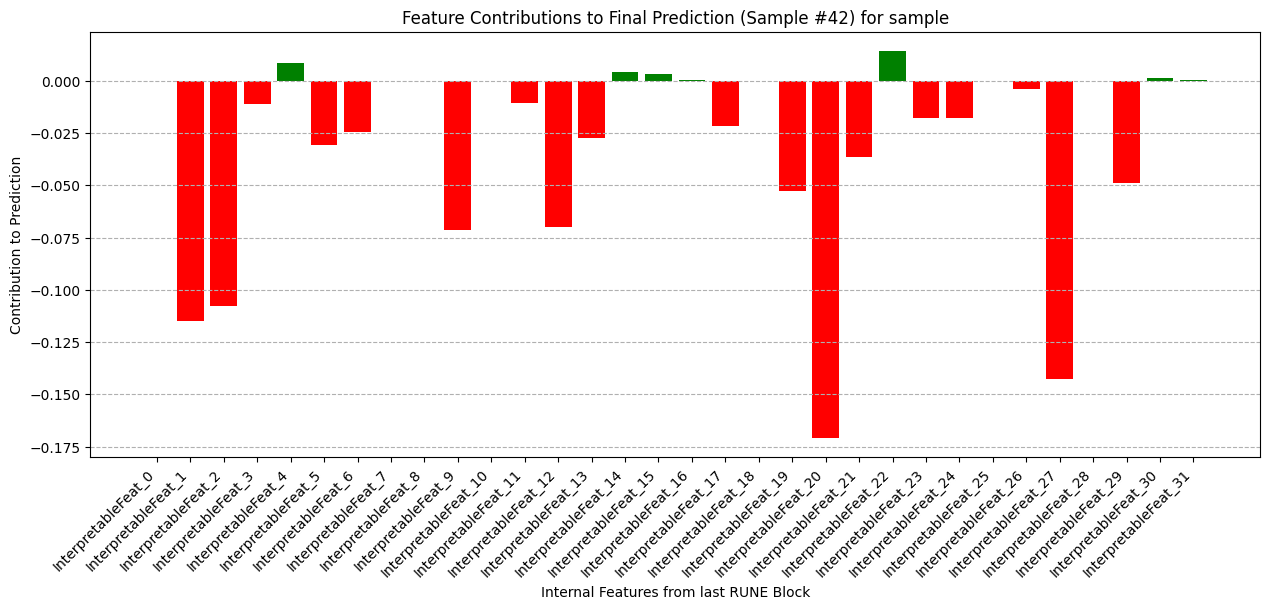

In [10]:
print("\n--- Interpretation 2: Final Layer Feature Contributions ---")
plt.figure(figsize=(12, 6))
interpret.plot_final_layer_contributions(
    model,
    x_sample,
    title=f"Feature Contributions to Final Prediction (Sample #{sample_idx})"
)
plt.xlabel("Internal Features from last RUNE Block")
plt.ylabel("Contribution to Prediction")
plt.show()

### 6.3. Deep Dive into the First RUNE Block
Let's look even deeper: how does the model form its very first "concepts"? We'll analyze the first `RuneBlock`.

*   **Gate Values**: Gates (sigmoids) decide which information from the previous layer passes through. A value near 1 means an "open" path, while a value near 0 means a "closed" one.
*   **Tropical Weights**: These weights are used in the `max-plus` operation. The higher the weight, the greater the influence the corresponding feature has when "competing" for the maximum.


--- Interpretation 3: Deep Dive into the First RUNE Block ---


/usr/local/lib/python3.11/dist-packages/rune/interpret.py:111: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/625736068.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


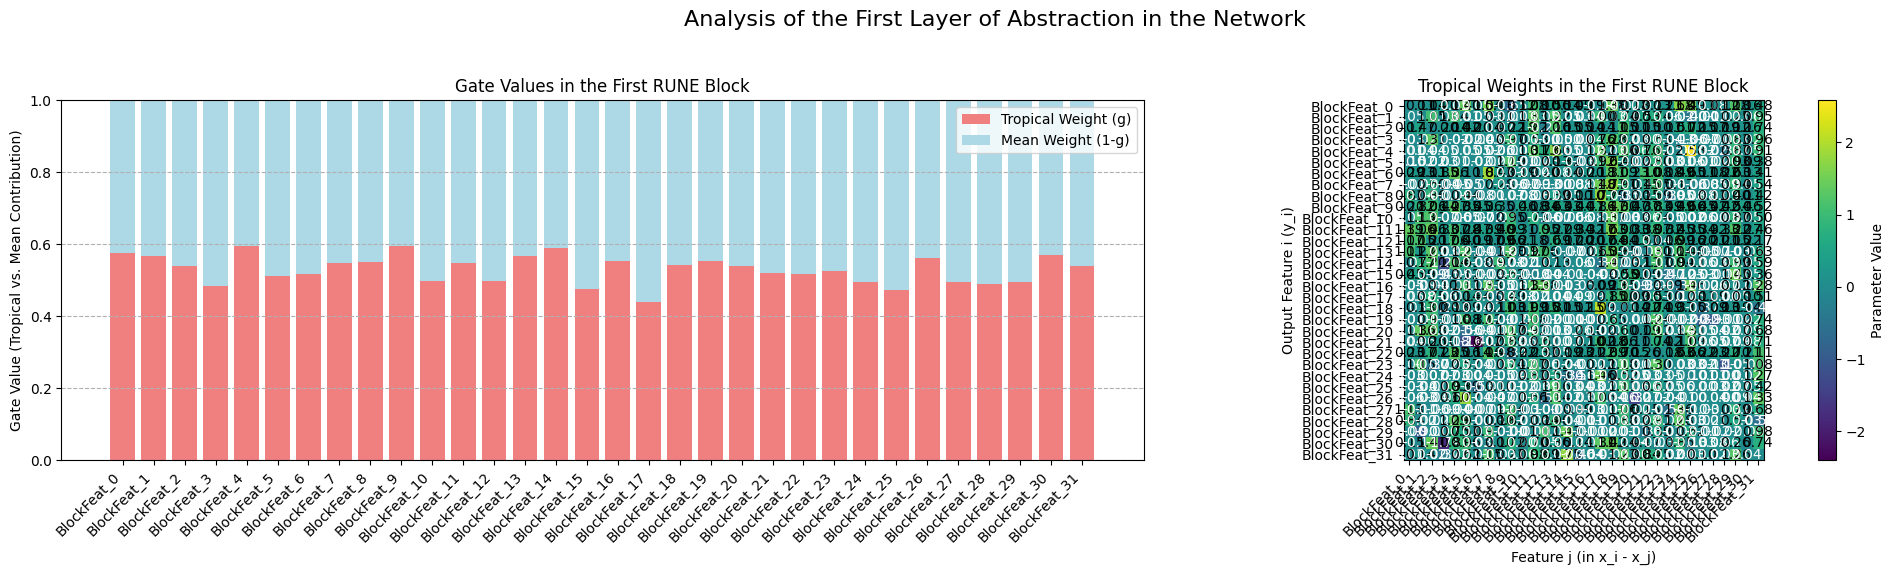

In [11]:
print("\n--- Interpretation 3: Deep Dive into the First RUNE Block ---")
first_block = model.rune_blocks[0]
gated_agg_layer = first_block.gated_agg
tropical_agg_sublayer = gated_agg_layer.tropical_agg
block_feature_names = [f"BlockFeat_{i}" for i in range(BLOCK_DIM)]

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the gates
interpret.plot_gated_aggregator_gates(
    gated_agg_layer,
    feature_names=block_feature_names,
    ax=axes[0],
    title="Gate Values in the First RUNE Block"
)

# Plot the tropical weights
interpret.plot_tropical_aggregator_params(
    tropical_agg_sublayer,
    param_type="weights",
    feature_names=block_feature_names,
    ax=axes[1],
    title="Tropical Weights in the First RUNE Block"
)
fig.suptitle("Analysis of the First Layer of Abstraction in the Network", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 6.4. Deconstructing Internal Features to Original Columns
This is arguably the most crucial step. How are the "concepts" we saw above related to the original, human-understandable features (`MedInc`, `HouseAge`, etc.)?

The model's input layer (`input_projection`) is a standard linear layer that creates the first internal representations. We can visualize its weights to see how each internal feature (`Proj_0`, `Proj_1`, ...) is formed from a combination of the original features.


--- Interpretation 4: Deconstructing Internal Features to Original Columns ---
This plot shows how the model creates its internal 'concepts' (Proj_*) from the original data.


<Figure size 1000x1200 with 0 Axes>

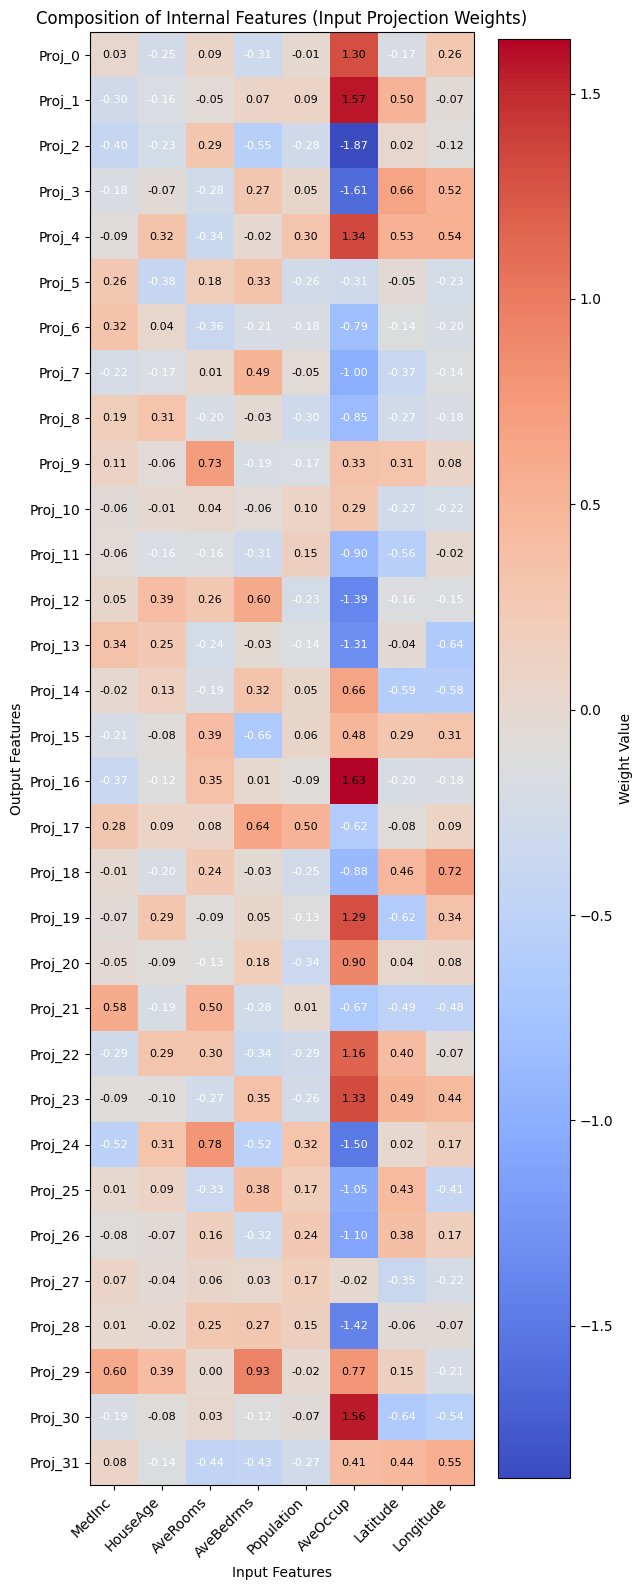

In [12]:
print("\n--- Interpretation 4: Deconstructing Internal Features to Original Columns ---")
print("This plot shows how the model creates its internal 'concepts' (Proj_*) from the original data.")

internal_feature_names = [f"Proj_{i}" for i in range(BLOCK_DIM)]

plt.figure(figsize=(10, 12))
interpret.plot_linear_weights(
    layer=model.input_projection,
    feature_names_in=feature_names_real,
    feature_names_out=internal_feature_names,
    title="Composition of Internal Features (Input Projection Weights)"
)
plt.show()